# Introduction to Brain Tumor Classification Using Deep Learning

In this Jupyter Notebook, we will be working on a brain tumor MRI dataset available from Kaggle [here](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset). The objective is to classify the MRI images into categories indicating that describe the type of brain tumors. We'll be investigating different machine learning models, data pre-processing methods, and various ways to evaluate the models.

## Project Members

- _Abdulrahman Alshahrani_
- _Savindu Wimalasooriya_
- _Mason Wilderom_
- _Kenny Nguyen_

## Background Information

Brain tumors are abnormal masses of cells in the brain that grow uncontrollably. They can be deadly because of the limited space in the brain. They can either be benign (noncancerous) or malignant (cancerous). These brain tumors come in many different shapes and forms, but in this notebook, we will only focus on three different types of tumors:

- ***glioma***
Gliomas are a common type of tumor originating from glial cells, which are the supportive tissue of the brain.

![A sample glioma case](data/Training/glioma/Tr-gl_0017.jpg)

- ***meningioma***
Meningiomas arise from the meninges, the membranous layers surrounding the brain and spinal cord. While they are typically benign and grow slowly, their location can still cause significant issues depending on the pressure they put on adjacent brain structures.

![A sample Meningiomas case](data/Training/meningioma/Tr-me_0017.jpg)

- ***pituitary***
Pituitary tumors are benign tumors that form in the pituitary gland, a small organ at the base of the brain that controls many important functions by releasing hormones into the bloodstream.

![A sample pituitary case](data/Training/pituitary/Tr-pi_0017.jpg)

- ***Control ("No Tumor")***
These are cases with no tumors found. They can be used to help Machine Learning models to learn if tumors exist or not.

![A sample No Tumor case](data/Training/notumor/Tr-no_0017.jpg)

## Importance of the Problem

As said above, these tumors are quite deadly. However, detecting these tumors quite early and esepcially with high precision can help patients get better treatment and potentially save their lives. Thus, it is very important to develop robust and accurate machine learning models that can identify these tumors and help doctors diagnose such cases better. 

## Dataset Description
 
The dataset is separated into two directories: *Testing* and *Training*. Each of those have 4 directories that correspond to the different image classifications mentioned above. All images are in `.jpg` and black & white.


### Imports

First lets setup the imports we need

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# Data Preparation

In this section, we will load the data, explore it, clean it, feature engineer it, and do changes as needed.

## Loading Data

First, we will load the dataset. While loading the data, we do the following:
- Open the images as grayscale values for each pixel
- Resize the images to 224x224
- Normalize the grayscale values using Mean + Std

We initially tried to just import the images. However, they had different sizes and this meant that they had different number of features, which would be hard to manage and use across different models. As for using grayscales, we realized that MRI images are just in black and white, so it would be a waste to consider all different RGB values for the image colors. As for the normalization, while none of the model we used explicitly need it, we decided to do it to simplify the computations and avoid large computations in some features.

In [2]:
def load_images_from_folder(folder_path):
    image_data = []
    labels = []
    for label_dir in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, label_dir)):
            for file in os.listdir(os.path.join(folder_path, label_dir)):
                file_path = os.path.join(folder_path, label_dir, file)
                image = Image.open(file_path).convert('L')
                image = image.resize((224, 224))
                image_array = np.array(image).flatten()
                image_data.append(image_array)
                labels.append(label_dir)
    
    # Normalize the image data
    mean_gray = np.mean(image_data) / 255.0
    std_gray = np.std(image_data) / 255.0
    image_data = [(img_data - mean_gray) / std_gray for img_data in image_data]

    return np.array(image_data), np.array(labels)

training_set_path = os.path.join('data', 'Training')
test_set_path = os.path.join('data', 'Testing')

training_dataset = load_images_from_folder(training_set_path)
test_dataset = load_images_from_folder(test_set_path)    

## Data Cleaning

As per the compiler of the dataset, they have already done data cleaning on the dataset, so we couldn't find much to change or clean. We tried to find any missing values or NaNs, but nothing showed up.

However, what is notable is that the Author noticed that one of the sources they used (SARTAJ dataset) to compile this dataset has had incorrect glioma classifications. Those cases were therefore removed.

In [3]:
print("Training dataset shape is ", training_dataset[0].shape)
print("Test dataset shape is ", test_dataset[0].shape)
print("number of NaN values in the training dataset is ", np.isnan(training_dataset[0]).sum())
print("number of NaN values in the     test dataset is ", np.isnan(test_dataset[0]).sum())

Training dataset shape is  (5712, 50176)
Test dataset shape is  (1311, 50176)
number of NaN values in the training dataset is  0
number of NaN values in the     test dataset is  0


## Data Exploration

Explore the data to understand its characteristics and structure. This can include visualizing image samples, their labels, and other relevant statistics.

Total number of images in the training set is  5712
Total number of images in the test set is  1311


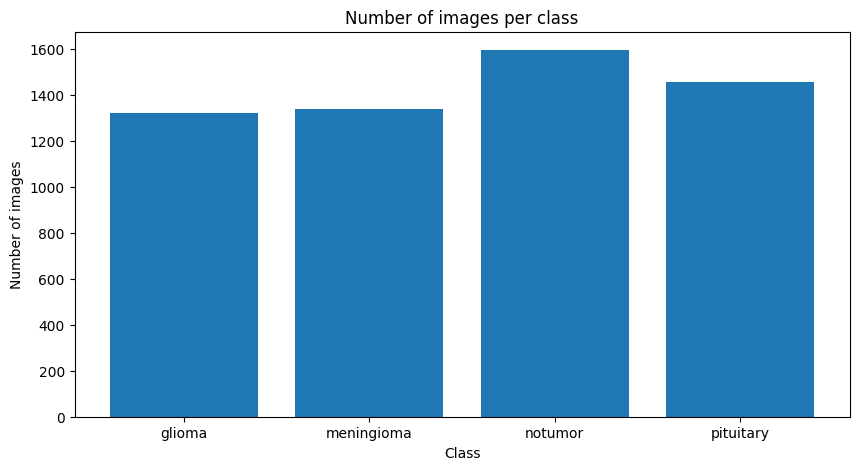

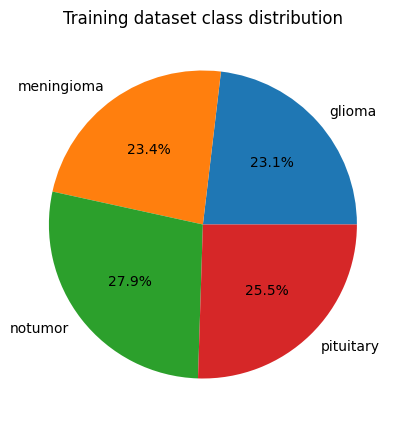

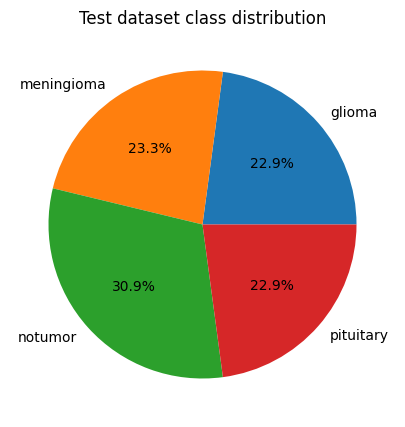

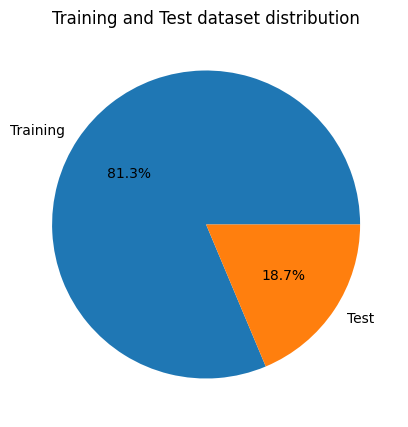

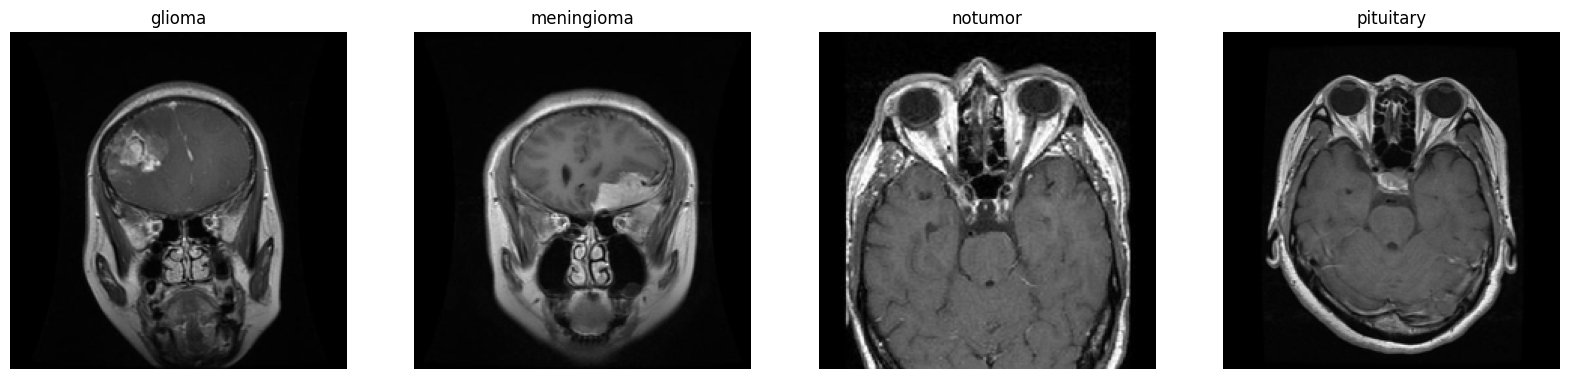

In [7]:
# print the total number of images in the training and test set
print("Total number of images in the training set is ", training_dataset[0].shape[0])
print("Total number of images in the test set is ", test_dataset[0].shape[0])

# display a bar graph of each class and the number of images in each class
labels, counts = np.unique(training_dataset[1], return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(labels, counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images per class')
plt.show()

# display 2 pie graphs for the distribution of the classes. Once for the training, once for the test set.
labels, counts = np.unique(training_dataset[1], return_counts=True)
plt.figure(figsize=(10, 5))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Training dataset class distribution')
plt.show()

labels, counts = np.unique(test_dataset[1], return_counts=True)
plt.figure(figsize=(10, 5))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Test dataset class distribution')
plt.show()

# display a pie graph for the distribution between training and test set
training_labels, training_counts = np.unique(training_dataset[1], return_counts=True)
test_labels, test_counts = np.unique(test_dataset[1], return_counts=True)
plt.figure(figsize=(10, 5))
plt.pie([training_counts.sum(), test_counts.sum()], labels=['Training', 'Test'], autopct='%1.1f%%')
plt.title('Training and Test dataset distribution')
plt.show()

# display an image for each classification
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
for i in range(4):
    image = training_dataset[0][training_dataset[1] == labels[i]][0].reshape(224, 224)
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(labels[i])
    ax[i].axis('off')
plt.show()


## Feature Engineering

In the previous steps, we did the following:
- Resize all of the images to (224, 224)
- Convert them to grayscales
- Normalize them using standard deviation and the mean
- We added a column that correspond's to each pixel's grayscale value

Initially, we used these features to proceed to the model training phase. However, the code was taking a very large amount of time. Therefore, we decided to do PCA to reduce the training time. Additionally, we realized that PCA should get rid of features that have low variance, and since there are many empty/black parts in our images, they will be removed. You can see the code we used for PCA below.

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
pca.fit(training_dataset[0])
training_dataset_pca = pca.transform(training_dataset[0])
test_dataset_pca = pca.transform(test_dataset[0])

X = training_dataset_pca
y = training_dataset[1]

print("Training dataset shape after PCA is ", training_dataset_pca.shape)
print("Test dataset shape after PCA is ", test_dataset_pca.shape)

Training dataset shape after PCA is  (5712, 1045)
Test dataset shape after PCA is  (1311, 1045)


# Modeling
In this section, we will set up the different Machine Learning algorithms we plan to use, evaluate them, and then analyze their results.

## Model Selection
For this project, we decided to run 5 different Machine Learning Algorithms, 4 that we studied before in class, and one new. Here they are:

- **Decision Trees**
We decided to use decision trees because they're one of the simplest algorithms that exist and it shouldn't be effected that much with higher dimensions. 

- **Support Vector Machines**
We decided to use SVMs because they are pretty robust in higher dimensions, i.e. they are not susceptible to the curse of dimensionality. While the data is pretty balanced, we still wanted to use SVMs to make sure that any uneven data representation is accounted for.

- **Random Forests**
We decided to use Random Forests because they are also robust in higher dimensions, i.e. not susceptible to the curse of dimensionality. We also choose them because they do not overfit to the training data easily, so they might perform better than the other models when tested on new data.

- **Multi-Layer Perceptrons**
We decided to use MLPs because they can detect complex patterns in the data sets because of their complex neural network. Also, they are quite flexible, so we can use hyperparameter to test many different values and potentially land on pretty robust configurations.

- **Convolutional Neural Networks**
We decided to use CNNs in this project because we heard that they are much better than the other models and are capable to capture unique patterns in image data. Additionally, we wanted to discover how modern neural networks work, from an learning purpose. :)

## Tuning the Models
For tuning the models, we decided to use GridSearchCV from scikit-learn to accurately test different hyperparameter configurations and choose the best ones. For most of them, we use a CV of 5, but we did have to use CV of 3 for the lengthy models.

### 1. Decision Trees

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [30, None],
    'min_samples_split': [10, 20]
}

grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_dt.fit(X, y)

# Best parameters and CV score
print("Best parameters:", grid_search_dt.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_dt.best_score_))

Best parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 10}
Best cross-validation score: 0.69


### 2. Support Vector Machines (SVMs)

In [15]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_svm.fit(X, y)

# Best parameters and CV score
print("Best parameters:", grid_search_svm.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_svm.best_score_))

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.82


### 3. Random Forests

In [16]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [30, None]
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, scoring='accuracy')
grid_search_rf.fit(X, y)

# Best parameters and CV score
print("Best parameters:", grid_search_rf.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_rf.best_score_))

Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100}
Best cross-validation score: 0.75


### 4. Multi-Layer Perceptrons (MLPs)

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import warnings

param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 100)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant', 'adaptive']
}

grid_search_mlp = GridSearchCV(estimator=MLPClassifier(max_iter=1000), param_grid=param_grid, cv=3, scoring='accuracy')

# Disable warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_search_mlp.fit(X, y)

# Best parameters and CV score
print("Best parameters:", grid_search_mlp.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_mlp.best_score_))

Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
Best cross-validation score: 0.68


### 5. Convolutional Neural Networks (CNNs)

Now we try a slightly more modern neural network and compare its performance with the previous models. This uses the tensorflow library

#### Convert the Labels to Numbers

Initially, we ran the algorithm with the `y` labels we had before, but this didn't work because the CNN needs numerical values for the `y` labels. Thus, let's convert the `y` labels to values first.

In [25]:
from sklearn.preprocessing import OneHotEncoder

y_encoded = OneHotEncoder(sparse_output=False).fit_transform(training_dataset[1].reshape(-1, 1))
test_y_encoded = OneHotEncoder(sparse_output=False).fit_transform(test_dataset[1].reshape(-1, 1))
num_classes = y_encoded.shape[1]

print("Encoded labels shape:", y_encoded.shape)
print("Encoded labels type:", type(y_encoded))
print("Number of classes:", num_classes)
print("Sample encoded labels:", y_encoded[667:])

Encoded labels shape: (5712, 4)
Encoded labels type: <class 'numpy.ndarray'>
Number of classes: 4
Sample encoded labels: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


##### Using Original Data instead of the PCA'd one

Since Convolutional Neural Networks leverage spacial connections between values, we shouldn't use the PCA'd dataset. 

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch, HyperParameters

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Specify how to build the model
    def build_model(hp):
        model = Sequential([

            # Reshape the input data
            Reshape((224, 224, 1), input_shape=(50176,)),

            # Add the first convolutional layer
            Conv2D(
                filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                activation='relu',
                input_shape=(224, 224, 1)
            ),
            MaxPooling2D(pool_size=(3, 3)),

            # Add the second convolutional layer
            Conv2D(
                filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
                kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                activation='relu',
                input_shape=(224, 224, 1)
            ),
            MaxPooling2D(pool_size=(3, 3)),

            # Add the third convolutional layer
            Conv2D(
                filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
                kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
                activation='relu',
                input_shape=(224, 224, 1)
            ),
            MaxPooling2D(pool_size=(3, 3)),


            # Flatten the output of the convolutional layers
            Flatten(),
            Dense(units=hp.Int('dense_1_units', min_value=448, max_value=544, step=32),
                activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
        return model

    # Initialize the hyperparameter tuner
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=5,
        directory='output',
        project_name='CNN_Tuning'
    )

    # Run hyperparameter tuning
    tuner.search(training_dataset[0], y_encoded, epochs=10, validation_split=0.1)

    # Print the results for the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"""
    The best model uses {best_hps.get('conv_1_filter')} filters in the first layer,
    a kernel size of {best_hps.get('conv_1_kernel')} and {best_hps.get('conv_2_filter')} filters in the second layer,
    a kernel size of {best_hps.get('conv_2_kernel')}, and {best_hps.get('dense_1_units')} dense units.
    It uses a learning rate of {best_hps.get('learning_rate')}.
    """)

    # Save the best model
    best_cnn_model = tuner.get_best_models(num_models=1)[0]

    print("Best CNN model summary:")
    print(best_cnn_model.summary())

Reloading Tuner from output\CNN_Tuning\tuner0.json

    The best model uses 128 filters in the first layer,
    a kernel size of 5 and 80 filters in the second layer,
    a kernel size of 3, and 512 dense units.
    It uses a learning rate of 0.0001.
    
Best CNN model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 220, 220, 128)  │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 71, 71, 80)     │        92,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 19, 19, 128)    │       256,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,713,556 (10.35 MB)

 Trainable params: 2,713,556 (10.35 MB)

 Non-trainable params: 0 (0.00 B)

None


## Model Evaluation

Now, we want to evaluate the performance of the models based on how good can they classify tumors.
Before, we were only looking at accuracy scores from CV tests, not on the actual test. Now, we want to properly test them, so we looked into the following metrics:
- Accuracy Score
- Precision
- Recall
- F1 Score

We measured those metrics for each model, as follows:

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Decision Tree
dt = DecisionTreeClassifier(**grid_search_dt.best_params_)
dt.fit(X, y)
dt_preds = dt.predict(test_dataset_pca)
dt_accuracy = accuracy_score(test_dataset[1], dt_preds)
dt_precision = precision_score(test_dataset[1], dt_preds, average='weighted')
dt_recall = recall_score(test_dataset[1], dt_preds, average='weighted')
dt_f1 = f1_score(test_dataset[1], dt_preds, average='weighted')

In [45]:
# SVM
svm = SVC(**grid_search_svm.best_params_)
svm.fit(X, y)
svm_preds = svm.predict(test_dataset_pca)
svm_accuracy = accuracy_score(test_dataset[1], svm_preds)
svm_precision = precision_score(test_dataset[1], svm_preds, average='weighted')
svm_recall = recall_score(test_dataset[1], svm_preds, average='weighted')
svm_f1 = f1_score(test_dataset[1], svm_preds, average='weighted')

In [46]:
# Random Forest
rf = RandomForestClassifier(**grid_search_rf.best_params_)
rf.fit(X, y)
rf_preds = rf.predict(test_dataset_pca)
rf_accuracy = accuracy_score(test_dataset[1], rf_preds)
rf_precision = precision_score(test_dataset[1], rf_preds, average='weighted')
rf_recall = recall_score(test_dataset[1], rf_preds, average='weighted')
rf_f1 = f1_score(test_dataset[1], rf_preds, average='weighted')

In [47]:
# MLP
mlp = MLPClassifier(**grid_search_mlp.best_params_)
mlp.fit(X, y)
mlp_preds = mlp.predict(test_dataset_pca)
mlp_accuracy = accuracy_score(test_dataset[1], mlp_preds)
mlp_precision = precision_score(test_dataset[1], mlp_preds, average='weighted')
mlp_recall = recall_score(test_dataset[1], mlp_preds, average='weighted')
mlp_f1 = f1_score(test_dataset[1], mlp_preds, average='weighted')

In [60]:
# CNN

cnn_preds = best_cnn_model.predict(test_dataset[0])
cnn_preds_indices = np.argmax(cnn_preds, axis=1)
true_labels_indices = np.argmax(test_dataset[1], axis=1) if test_dataset[1].ndim > 1 else test_dataset[1]

# Convert true labels to indices
class_mapping = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

mapped_true_labels = np.array([class_mapping[label] for label in true_labels_indices], dtype=int)
mapped_predictions = np.array(cnn_preds_indices, dtype=int)

# Calculate the metrics using mapped values
cnn_accuracy = accuracy_score(mapped_true_labels, mapped_predictions)
cnn_precision = precision_score(mapped_true_labels, mapped_predictions, average='weighted')
cnn_recall = recall_score(mapped_true_labels, mapped_predictions, average='weighted')
cnn_f1 = f1_score(mapped_true_labels, mapped_predictions, average='weighted')

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step


In [61]:
# Save the results
results = {
    'Model': ['Decision Tree', 'SVM', 'Random Forest', 'MLP', 'CNN'],
    'Accuracy': [dt_accuracy, svm_accuracy, rf_accuracy, mlp_accuracy, cnn_accuracy],
    'Precision': [dt_precision, svm_precision, rf_precision, mlp_precision, cnn_precision],
    'Recall': [dt_recall, svm_recall, rf_recall, mlp_recall, cnn_recall],
    'F1 Score': [dt_f1, svm_f1, rf_f1, mlp_f1, cnn_f1]
}

### Display the Model Evaluations

Reading the values as text might be a bit difficult to understand and visualize, so let's look at the values graphed, one graph per metric.

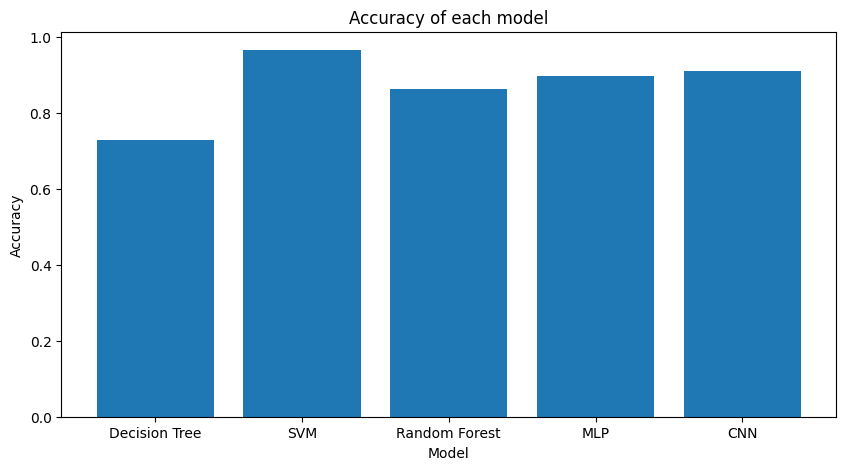

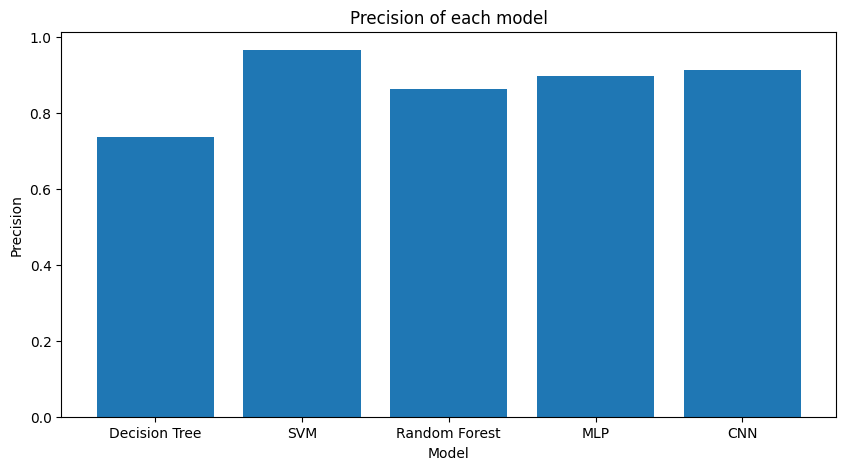

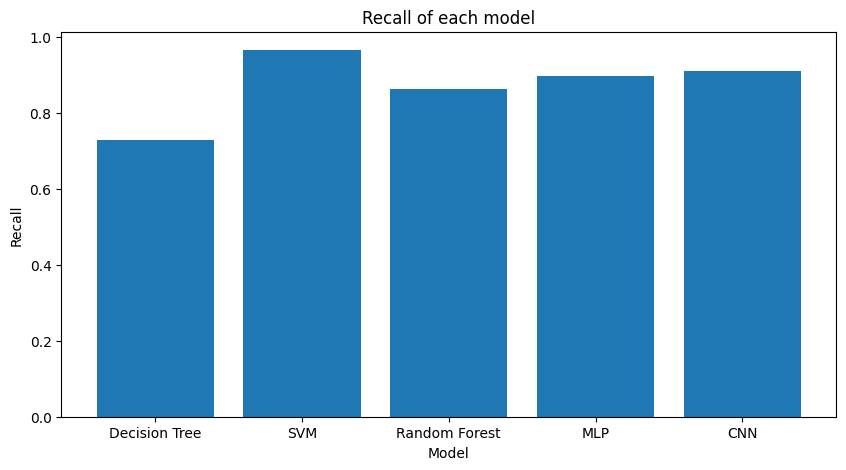

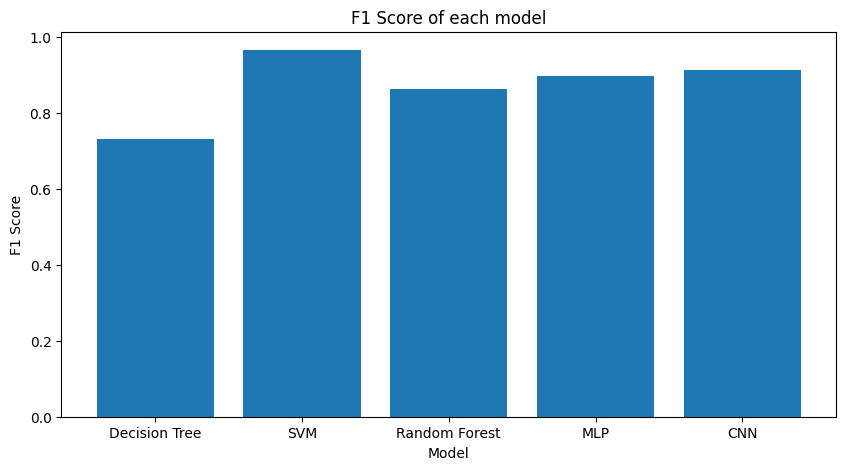

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.729214,0.737134,0.729214,0.732103
1,SVM,0.966438,0.966421,0.966438,0.966155
2,Random Forest,0.864989,0.864964,0.864989,0.863811
3,MLP,0.898551,0.897514,0.898551,0.897409
4,CNN,0.912281,0.914176,0.912281,0.912513


In [62]:
# Display the results in graphs
plt.figure(figsize=(10, 5))
plt.bar(results['Model'], results['Accuracy'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of each model')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(results['Model'], results['Precision'])
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision of each model')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(results['Model'], results['Recall'])
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall of each model')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(results['Model'], results['F1 Score'])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score of each model')
plt.show()

# Save the results in a DataFrame
results_df = pd.DataFrame(results)
results_df

### Display Confusion Matrices

Now, let's look at the Confusion Matrices of these models

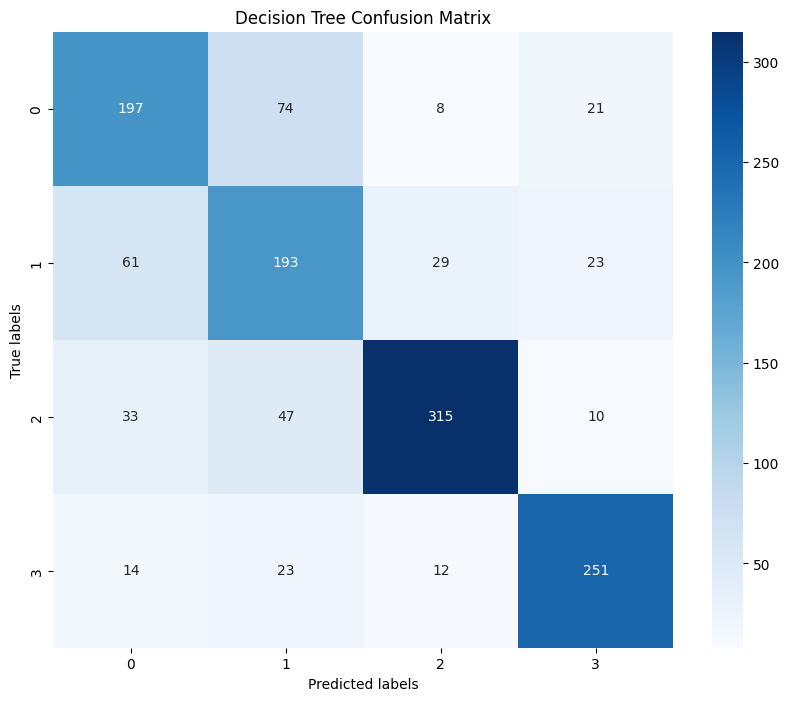

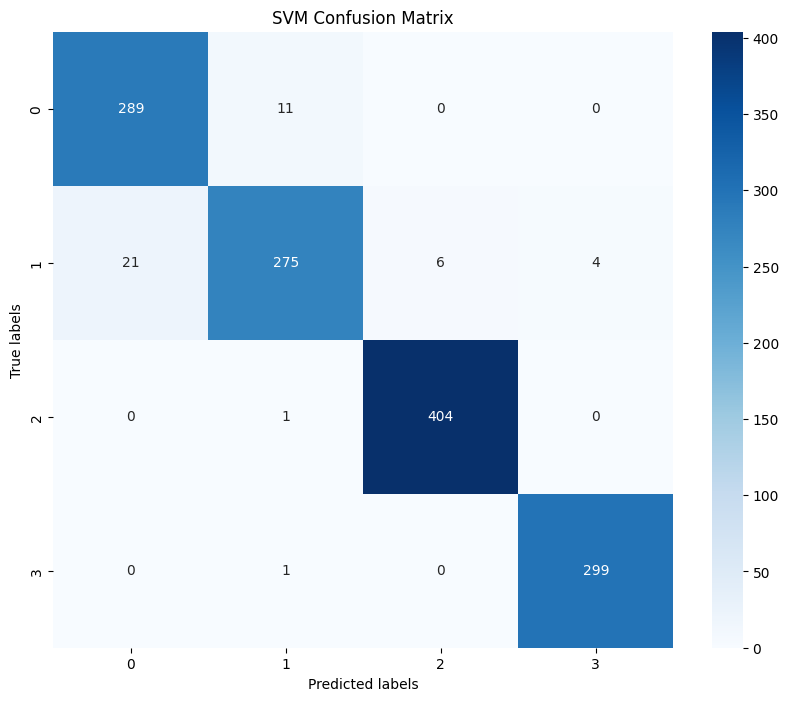

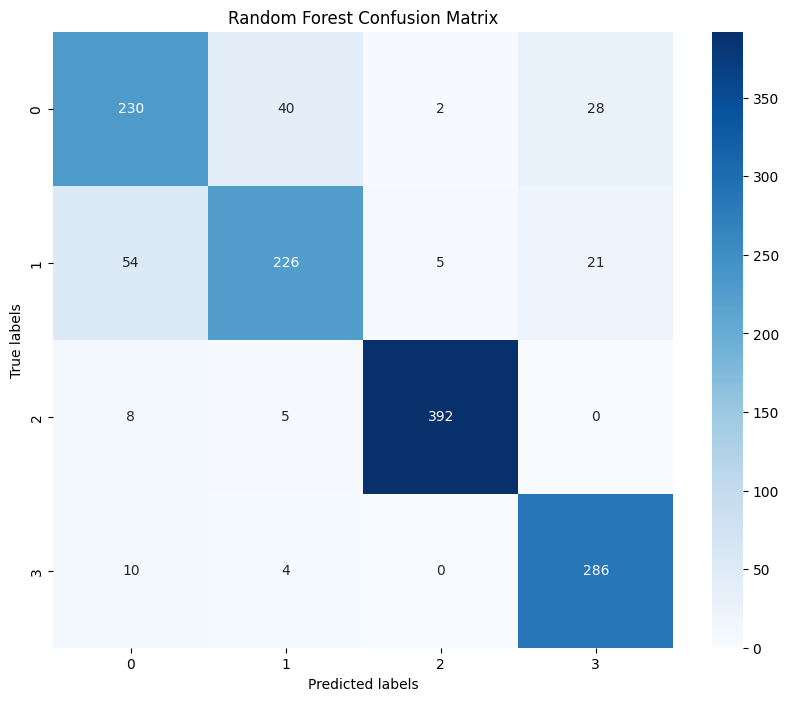

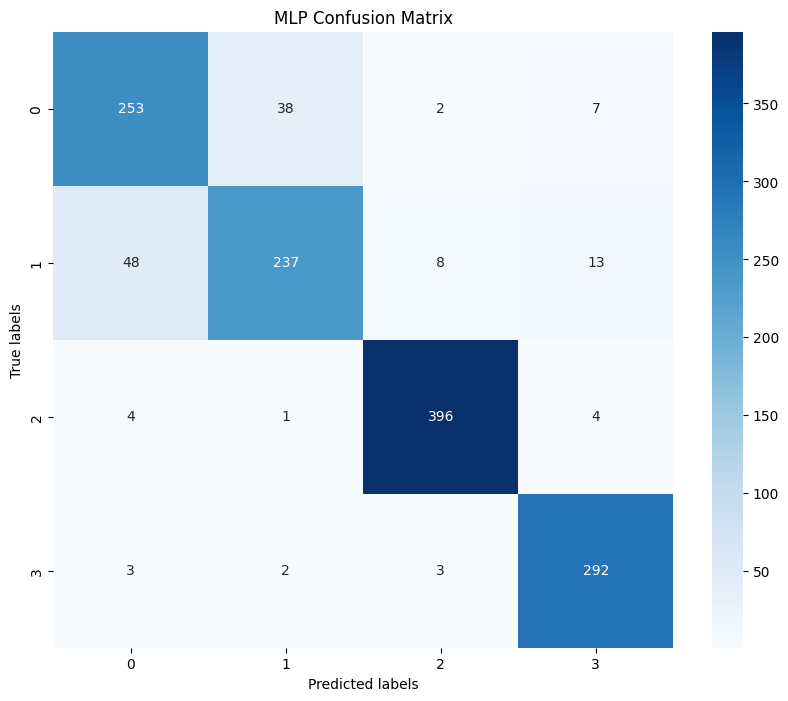

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step


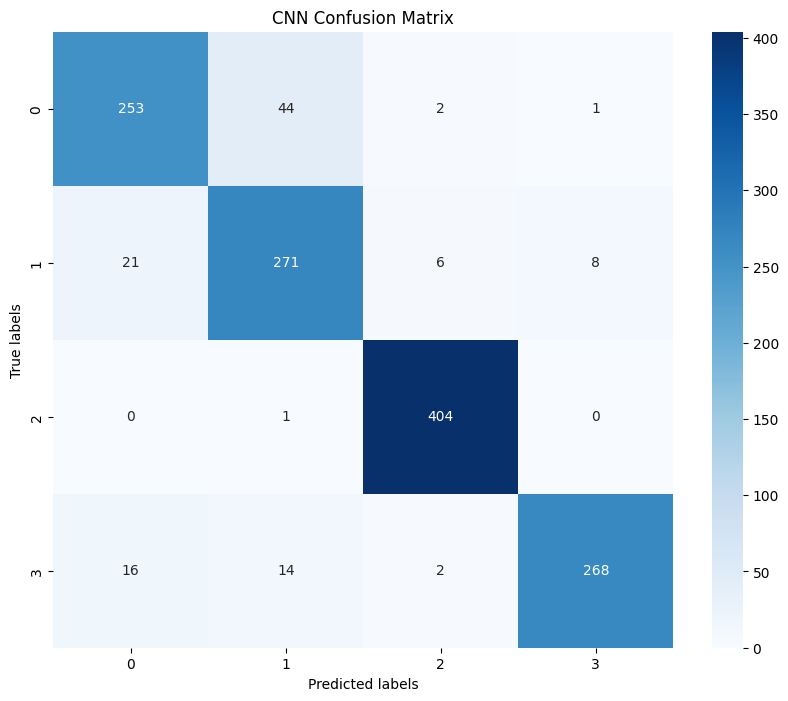

In [63]:
# print the confusion matrices for each model
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Decision Tree
dt_cm = confusion_matrix(test_dataset[1], dt_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Decision Tree Confusion Matrix')
plt.show()

# SVM
svm_cm = confusion_matrix(test_dataset[1], svm_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SVM Confusion Matrix')
plt.show()

# Random Forest
rf_cm = confusion_matrix(test_dataset[1], rf_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Confusion Matrix')
plt.show()

# MLP
mlp_cm = confusion_matrix(test_dataset[1], mlp_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('MLP Confusion Matrix')
plt.show()

# CNN
true_labels_indices = np.array([class_mapping[label] for label in test_dataset[1]], dtype=int)
predicted_labels = np.argmax(best_cnn_model.predict(test_dataset[0]), axis=1)
cnn_cm = confusion_matrix(true_labels_indices, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('CNN Confusion Matrix')
plt.show()



# Conclusion

## Best Model?
### SVMs
Looking at the results, we can clearly see that SVMs performed the best when compared with the other models. It has an accuracy of 0.97 where the next model, CNN, has an accuracy of 0.91.

It was a bit surprising to see that the CNN model performed worse than SVMs, considering the many things we heard about CNNs. It could be because our search options weren't than broad. Initially, we thought that even if we managed to get CNNs to work with higher accuracy than SVMs, we will probably still consider SVMs to be the best.

Why? Because SVMs were much simpler to set up and train, compared to the CNNs which needed a different library--TensorFlow--and a complex layering step. Additionally, SVMs only took 6 mins to train, while the current CNN configuration needed about 90 mins to train on my PC.

However, after careful thought, we realized that we're dealing with senstive tumor diagnosis cases, where accuracy is the most important aspect. If switching to CNNs will yield better accuracies, the overhead cost of more complex system and more training time is negligible, when compared with the potential amount of lives saved by this improvement.

Overall, we think the dataset was pretty interesting and posed lots of challenges for us. We had to figure out how to standarize the different image sizes, and how to convert them to readable arrays that can be used in actual datasets.

# Final Model

Given that the SVM model performed the best on the dataset, let's build one final model using all the data we have (both training and testing) so the model would be ready for commercial use.

The model should be saved as a `.pkl` file using the `joblib` library.

In [64]:
# Reimport the datasets and merge them
final_training_dataset = load_images_from_folder(training_set_path)
final_test_dataset = load_images_from_folder(test_set_path)
final_X = np.concatenate((final_training_dataset[0], final_test_dataset[0]))
final_y = np.concatenate((final_training_dataset[1], final_test_dataset[1]))

# Perform PCA on the full dataset
final_pca = PCA(n_components=0.95)
final_pca.fit(final_X)
final_X_pca = final_pca.transform(final_X)

# Train the SVM model on the full dataset
final_svm = SVC(**grid_search_svm.best_params_)
final_svm.fit(final_X_pca, final_y)

# Save the final SVM model
import joblib
joblib.dump(final_svm, 'final_model.pkl')

['final_model.pkl']